# Introduction to Photometry

### Dora Föhring, University of Hawaii Institute for Astronomy

Aim: Demonstrate photometry on a series of bias and flat field corrected images of a Near Earth Asteroid. 

## 0. Prerequisites

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
## make matplotlib appear in the notebook rather than in a new window
%matplotlib inline

### 0.1 Directory Set up

In [157]:
datadir = './psf_files/'
objname  = '2016HO3'

### 0.2 Display images

In [158]:
def plotfits(imno):
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(numb))[0].data

    f = plt.figure(figsize=(10,12))
    #im = plt.imshow(img, cmap='hot')
    im = plt.imshow(img[480:580, 460:600], cmap='hot', origin = 'lower')
    plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.034, pad=0.04)
    plt.savefig("figure{0}.png".format(imno))
    plt.show()
    
    return img

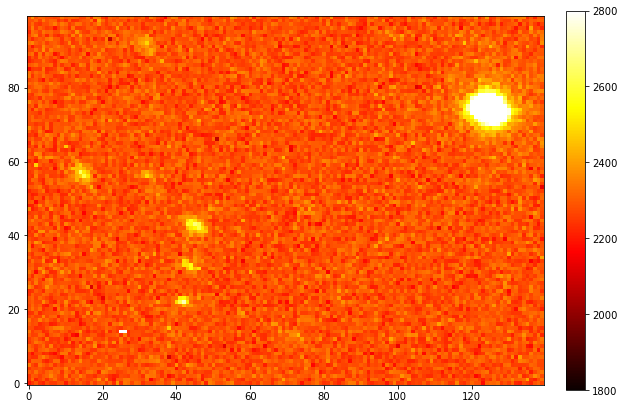

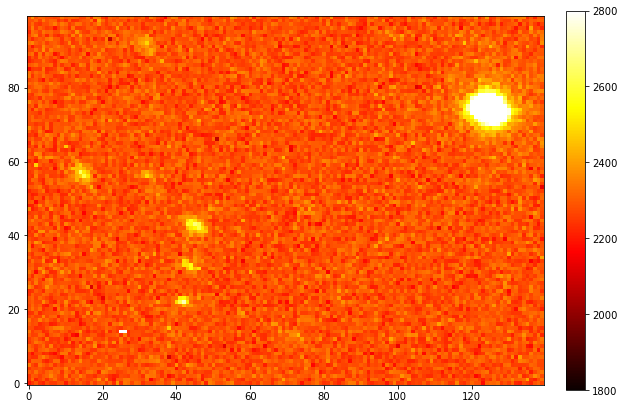

In [159]:
numb = 1 
plotfits(numb)
img = plotfits(numb)

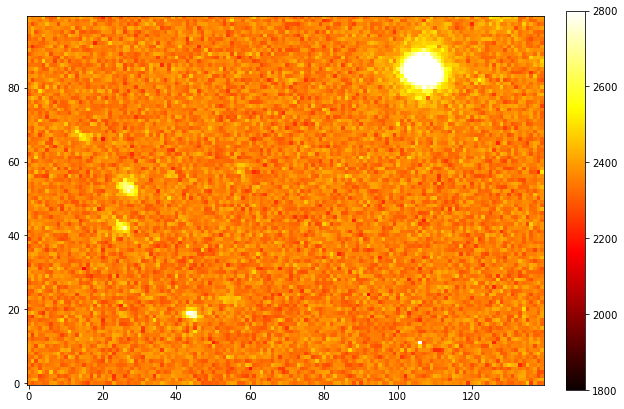

array([[  4079.28759766,   4079.28759766,   2332.17089844, ...,
          2389.7590332 ,   2342.34936523,   2323.74023438],
       [     0.        ,   2340.51757812,   2347.05297852, ...,
          2347.12866211,   2327.71191406,   2287.96972656],
       [  8797.76757812,   2443.91113281,   2381.30493164, ...,
          2291.57543945,   2333.31030273,   2326.76757812],
       ..., 
       [     0.        ,   2321.57958984,   2374.98486328, ...,
          2321.72387695,   2354.30297852,   2350.39697266],
       [ 18234.01953125,   2267.88574219,   2342.27636719, ...,
          2346.79321289,   2296.3137207 ,   2391.61108398],
       [  1160.06518555,   2414.94238281,   2319.89599609, ...,
          2330.0534668 ,   2381.3996582 ,   2369.19238281]], dtype=float32)

In [160]:
numb = 2
plotfits(numb)



In [161]:
len(img)
import numpy as np
print (np.sqrt(1024))

32.0


## 1. Photometry set up

Select part of the image for ease of display.

In [162]:
partimg = fits.open(datadir+objname+'_01.fits'.format(numb))[0].data[480:580, 460:600]

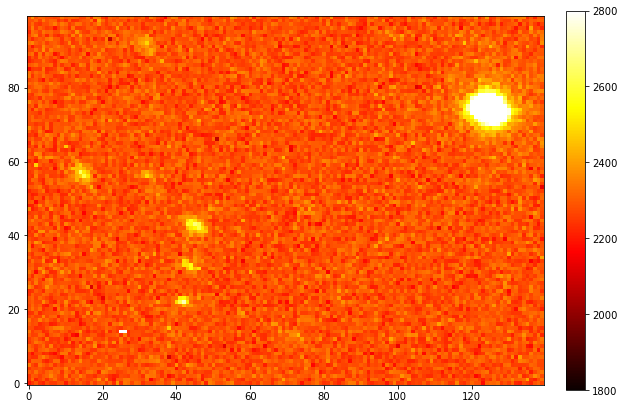

array([[ 2195.46850586,  2248.80859375,  2293.47827148, ...,
         2290.74121094,  2311.97485352,  2272.83349609],
       [ 2245.16821289,  2325.31542969,  2214.8112793 , ...,
         2217.91088867,  2283.26733398,  2334.16040039],
       [ 2237.81958008,  2300.10791016,  2291.73754883, ...,
         2376.08007812,  2331.46850586,  2274.04418945],
       ..., 
       [ 2272.51171875,  2320.10668945,  2254.48779297, ...,
         2255.98754883,  2200.94433594,  2261.47436523],
       [ 2283.53271484,  2287.76879883,  2316.2355957 , ...,
         2300.2746582 ,  2323.40185547,  2310.53881836],
       [ 2277.63549805,  2376.49145508,  2283.79467773, ...,
         2221.55566406,  2307.80102539,  2288.42333984]], dtype=float32)

In [163]:
def plotfits_image(img):
    
    f = plt.figure(figsize=(10,12))
    im = plt.imshow(img, cmap='hot', origin = 'lower')
    plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.034, pad=0.04)
    plt.show()
    
    return img
    
plotfits_image(partimg)

Define starting values. Fill in values here:

In [164]:
targcen = np.array([22,42])  ## target center
compcen = np.array([75,125])  ## comparison center

Aperture photometry set up. Play around with adjusting the aperture radii sizes and see the resulting image under 'Tests'

In [165]:
searchr = 6  ## search box size
ap_r    = 2   ## aperture radius

sky_inner = 3
sky_outer = 5

### 1.1 Centroiding: Center of Mass

Calculate Center of Mass (CoM) defined as: $\bar{x} = \frac{\sum A_i x_i}{\sum A_i }$, $\bar{y} = \frac{\sum A_i  y_i}{\sum A_i }$.

In [166]:
cent=np.zeros((2),np.float)
cent[0]

0.0

In [167]:
def cent_weight(n):
    """
    Assigns centroid weights
    """
    wghts=np.zeros((n),np.float)
    for i in range(n):
        wghts[i]=float(i-n/2)+0.5
    return wghts

def calc_CoM(psf, weights):
    """
    Finds Center of Mass of image
    """
    cent=np.zeros((2),np.float)
    temp = sum(sum(psf) - min(sum(psf)))
    cent[1] = sum((sum(psf) - min(sum(psf))) * weights) / temp
    cent[0] = sum((sum(psf.T) - min(sum(psf.T))) * weights)/ temp
    return cent

Use centroiding algorithm to find the actual centers of the target and comparison.

In [168]:
## Cut a box between search limits, centered around targcen
targbox = partimg[targcen[0]-searchr : targcen[0]+searchr, targcen[1]-searchr : targcen[1]+searchr]
weights = cent_weight(len(targbox))
tcenoffset = calc_CoM(targbox, weights)
print(tcenoffset)
tcenter = targcen + tcenoffset

[ 0.28626991  0.27630925]


Inspect PSF to see whether shift makes sense

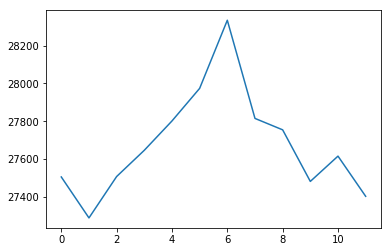

In [169]:
plt.plot(sum(targbox))
plt.show()

In [170]:
compbox = partimg[compcen[0]-searchr : compcen[0]+searchr, compcen[1]-searchr : compcen[1]+searchr]
compw = cent_weight(len(compbox))
ccenoffset = calc_CoM(compbox,compw)
ccenter = compcen + ccenoffset

In [171]:
print(tcenter)

[ 22.28626991  42.27630925]


In [172]:
compw

array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,
        5.5])

### 1.2 Aperture Photometry

#### Science Aperture

In [173]:
def circle(npix, r1):
    """
    Builds a circle
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            if np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2) <= r1:
                print('pup goes to 1')
                pup[i,j]=1
    return pup

In [174]:
circmask

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

#### Sky annulus

In [175]:
def annulus(npix, r_inner,r_outer=-1.):
    """
    Builds an annulus
    """
    
    pup=np.zeros((npix,npix),np.int)
    r = 0
    for i in range(npix):
        for j in range(npix):
            r = np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if ((r<=r_outer)&(r>=r_inner)):
                print('pup goes to 1')
                pup[i,j]=1
    return pup

#### Extract values from regions

Create mask

In [176]:
circmask = circle(searchr*2, ap_r)
annmask = annulus(searchr*2, sky_inner, sky_outer)
annmask

pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1
pup goes to 1


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Define new regions where the target and comparison are centered.

In [177]:
newtarg = partimg[int(round(tcenter[0]))-searchr : int(round(tcenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]
newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(ccenter[1]))-searchr : int(round(ccenter[1]))+searchr]

Place mask on region

In [178]:
targaper = newtarg * circmask
compaper = newcomp * circmask

Place mask on sky annulus slice. 

In [179]:
targann = newtarg * annmask
compann = newcomp * annmask

annmask

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 1.3 Tests

a. Display image with target and comparison centers before and after centroiding

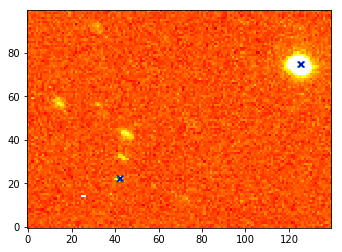

In [180]:
im = plt.imshow(partimg, cmap='hot', origin = 'lower')
plt.clim(1800, 2800)
plt.scatter(targcen[1], targcen[0], c='g', marker='x')
plt.scatter(compcen[1], compcen[0], c='g', marker='x')
plt.scatter(tcenter[1], tcenter[0], c='b', marker='x')
plt.scatter(ccenter[1], ccenter[0], c='b', marker='x')
plt.show()

b. Disply image with aperture mask and sky annulus

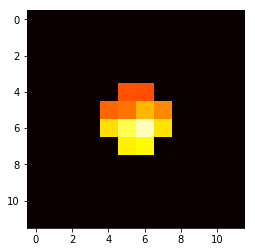

In [181]:
im = plt.imshow(targaper, cmap='hot')
plt.clim(1800, 2800)
plt.show()

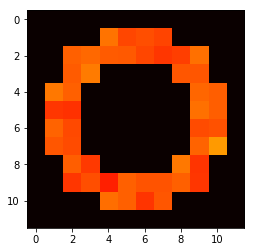

In [182]:
im = plt.imshow(targann, cmap='hot')
plt.clim(1800, 2800)
plt.show()

## 2. Photometry

### 2.1 Calculate SNR

Calculate Signal-to-Noise Ratio. CCD noise = sqrt(signal + background + dark current + read noise). Ignore dark current and read noise here. 

In [183]:
def calcsnr(target, bg):
    signal = target - bg
    noise = np.sqrt(signal + bg)
    snr = signal / noise
    return snr, noise   

Sum all flux inside target and comparison apertures and divide by number of pixels to get average count per pixel.

In [184]:
targc = np.sum(targaper) / np.sum(circmask)
targbg= np.sum(targann) /  np.sum(annmask)
compc = np.sum(compaper) /  np.sum(circmask)
compbg= np.sum(compann) /  np.sum(annmask)

In [185]:
np.sum(annmask)

48

In [186]:
snr, noise = calcsnr(targc, targbg)
print(snr)

3.25785930576


In [154]:
snr, noise = calcsnr(compc, compbg)
print(snr)

170.310735282


### 2.2 Optimize photometry aperture

In [65]:
## Write code here that tries a range of photometry apertures and finds the best SNR ##

In [220]:
def circle(npix, r1):
    """
    Builds a circle
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            if np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2) <= r1:
                pup[i,j]=1
    return pup

def annulus(npix, r_inner,r_outer=-1.):
    """
    Builds an annulus
    """
    
    pup=np.zeros((npix,npix),np.int)
    r = 0
    for i in range(npix):
        for j in range(npix):
            r = np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if ((r<=r_outer)&(r>=r_inner)):
                pup[i,j]=1
    return pup

def calcsnr(target, bg):
    signal = target - bg
    noise = np.sqrt(signal + bg)
    snr = signal / noise
    return snr, noise 

def test_snr(searchr, ap_r, sky_inner, sky_outer):
    circmask = circle(searchr*2, ap_r)
    annmask = annulus(searchr*2, sky_inner, sky_outer)
    newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(ccenter[1]))-searchr : int(round(ccenter[1]))+searchr]
  
    compaper = newcomp * circmask
    compann = newcomp * annmask
    
    compc = np.sum(compaper) /  np.sum(circmask)
    compbg= np.sum(compann) /  np.sum(annmask)
    
    snr, noise = calcsnr(compc, compbg)
    return snr

searchr = 10
sky_inner = 3
sky_outer = 5

snr_values = []
r_values = np.arange(1, 10, 0.1)
r_values
N_trials = len(r_values)

for i in range(N_trials):
    snr_values.append(test_snr(searchr, r_values[i], sky_inner, sky_outer))
    

In [221]:
snr_values

[211.32831140386293,
 211.32831140386293,
 211.32831140386293,
 211.32831140386293,
 211.32831140386293,
 211.32831140386293,
 170.31073528198678,
 170.31073528198678,
 170.31073528198678,
 170.31073528198678,
 170.31073528198678,
 170.31073528198678,
 158.65092012482197,
 158.65092012482197,
 158.65092012482197,
 158.65092012482197,
 134.33049425144378,
 134.33049425144378,
 134.33049425144378,
 134.33049425144378,
 119.72205235847363,
 119.72205235847363,
 119.72205235847363,
 119.72205235847363,
 119.72205235847363,
 119.72205235847363,
 100.28116218989544,
 100.28116218989544,
 100.28116218989544,
 90.998616525904609,
 90.998616525904609,
 90.998616525904609,
 90.998616525904609,
 90.998616525904609,
 82.92068421606136,
 82.92068421606136,
 75.957405789890174,
 75.957405789890174,
 70.037221845284733,
 70.037221845284733,
 67.374202126745388,
 67.374202126745388,
 62.545315146988429,
 62.545315146988429,
 62.545315146988429,
 62.545315146988429,
 58.245293072399711,
 58.24529307239

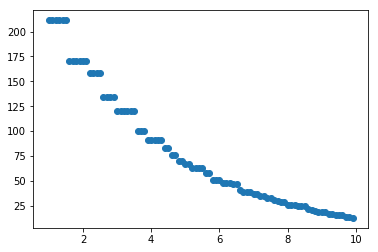

In [222]:
plt.scatter(r_values, snr_values)

### 2.3 Calculate the target's magnitude and uncertainty


Given the comparison is of known magnitude of 19.4

In [ ]:
targc = circle(searchr*2, ap_r)*newtarg
targskyc = annulus(searchr*2, sky_inner, sky_outer)*newtarg
compc = circle(searchr*2, ap_r)*newcomp
compskyc = annulus(searchr*2, sky_inner, sky_outer)*newcomp

ratio = np.sum(compc)/np.sum(targc)
### complete here ###
### complete here ###
### complete here ###

refmag = 19.4
### complete here ###
print("Measured Magnitude = {:0.3f} ± {:0.3f}".format(mag, sigmamag))

# Further Exercises

a. Perform photometry on all 10 images of the asteroid and find its period of rotation.

b. Perform photometry using Gaussian PSF fitting. 